In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import umap

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets
import numpy as np

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [4]:
raw_data = pd.read_csv("data/heart.csv")
original_data = raw_data.drop(columns=["target"])
training_labels = raw_data["target"]
raw_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 50, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 25, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=10, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [6]:
## Need to define a scaling function that ignores categorical values...?

In [7]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                700       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                260       
_________________________________________________________________
dropout_3 (Dropout)  

Using TensorFlow backend.


In [8]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.1)    

pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)

pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Instructions for updating:
Use tf.cast instead.
Fold: 0 -> Loss:0.536, Acc:0.8872
Prediction Accuracy
28/28 [==============================] - 0s 3ms/step
Scores on data set: loss=0.889 accuracy=0.6786
Fold Correct: 19
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Running worker: 1
Fold: 1 -> Loss:0.588, Acc:0.8383
Prediction Accuracy
28/28 [==============================] - 0s 23us/step
Scores on data set: loss=0.550 accuracy=0.7857
Fold Correct: 22
Running worker: 2
Fold: 2 -> Loss:0.584, Acc:0.8684
Prediction Accuracy
28/28 [==============================] - 0s 21us/step
Scores on data set: loss=0.515 accuracy=0.8929
Fold Correct: 25
Running worker: 3
Fold: 3 -> Loss:0.609, Acc:0.8609
Prediction Accuracy
28/28 [==============================] - 0s 23us/step
Scores on data set: loss=0.425 accuracy=0.9286
Fold Correct: 26
Running worker: 4
Fold: 4 -> Loss:0.553, Acc:0.8496
Prediction Accuracy
27/27 [=====

Confusion matrix, without normalization
[[0.78225806 0.21774194]
 [0.11486486 0.88513514]]


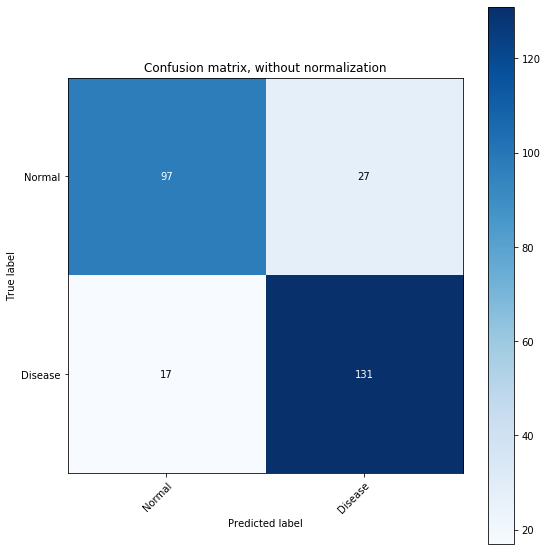

In [9]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

In [10]:
# from plotly.offline import iplot
# from plotly.offline import plot

# accs = nn.history.history["acc"]
# loss = nn.history.history["loss"]

# accs_plot = go.Scatter(
#     x=[x for x in range(1,len(accs)+1)],
#     y=accs,
#     mode="lines",
#     name="line plot"
# )

# data = [accs_plot]

# layout = go.Layout(
#     title= "Training History",
#     yaxis= {"title":"Accuracies"},
#     xaxis={"title":"Epoch"}
# )

# fig = go.Figure(data=data, layout=layout)


# iplot(fig)

In [10]:
# min_cluster_sizes=range(3,20,1)
pipeline.train_clusterer(plot=False)

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:725: NumbaWarning:

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:734

Minimum Size:
Clusters                  (12, 12)
Noise                     (12, 12)
Halkidi                   (12, 12)
Halkidi-Filtered Noise    (12, 12)
dtype: object


,Clusters,Noise,Halkidi,Halkidi-Filtered Noise
"(12, 12)",2,0.0,0.516517,0.516517
"(13, 12)",2,0.0,0.516517,0.516517
"(13, 13)",2,0.0,0.516517,0.516517
"(14, 12)",2,0.0,0.516517,0.516517
"(14, 13)",2,0.0,0.516517,0.516517
"(14, 14)",2,0.0,0.516517,0.516517
"(15, 12)",2,0.0,0.516517,0.516517
"(15, 13)",2,0.0,0.516517,0.516517
"(15, 14)",2,0.0,0.516517,0.516517
"(15, 15)",2,0.0,0.516517,0.516517


In [11]:
pd.Series(pipeline.clusterer.labels_).value_counts()

0    71
1    60
dtype: int64

In [12]:
# Internally populates self.val_set_lrp
samples, cluster_labels = pipeline.get_validation_clusters()

Loading LRP Analyzers...
Done!


In [13]:
pd.Series(cluster_labels).value_counts()

0    16
dtype: int64

## Plotting Relevance Clusters

In [14]:
training_lrp = pipeline.training_lrp
val_lrp = pipeline.val_set_lrp
training_lrp.shape

(131, 13)

In [18]:
# pipeline.reducer_pipeline[0].n_neighbors
embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(training_lrp)

embedding = embedding_pipeline.transform(training_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=5,
        color=pipeline.clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8
    ),
    text=pipeline.clusterer.labels_
)

val_3d_embedding = embedding_pipeline.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    name="Validation",
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
#         showscale=True
    ),
    text = cluster_labels
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5',
#     template="plotly"
)


data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
# fig.update_layout(template="plotly")  /

iplot(fig, filename='lrp-3d-scatter.html')

# Performing Feature Reduction

In [19]:
def get_relevant_cols(df, thresh = 1e-2):

    all_above_thresh = (df < thresh).all(0) #Check if all values in columns satisfy the criteria
    max_above_thresh = (df.max() < thresh)
    quantile_above_thresh = (df.quantile(0.8) <= thresh)

    criteria = quantile_above_thresh
    irrelevant_cols = df.columns[criteria] 
    irrelevant_cols
    
    relevant_features_only = df.drop(columns = irrelevant_cols)
    
    return relevant_features_only

## Getting largest subcluster samples from validation set

In [20]:
largest_cluster = pd.Series(cluster_labels).value_counts().idxmax()
largest_cluster

0

In [21]:
cluster_label = largest_cluster
val_clustered = pd.DataFrame(val_lrp[(cluster_labels == cluster_label)], columns = X_train.columns)

In [22]:
val_clustered.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,16.0,16.0,16.000000,16.0,16.000000,16.0,16.000000,16.000000,16.0,16.0,16.000000,16.0,16.0
mean,0.0,0.0,0.021091,0.0,0.060733,0.0,0.001145,1.006602,0.0,0.0,0.006225,0.0,0.0
std,0.0,0.0,0.018377,0.0,0.087016,0.0,0.001502,0.396540,0.0,0.0,0.003982,0.0,0.0
min,0.0,-0.0,0.000000,0.0,0.000000,-0.0,0.000000,0.555628,0.0,0.0,0.000000,-0.0,0.0
25%,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.751664,-0.0,0.0,0.003504,0.0,0.0
50%,0.0,-0.0,0.019196,0.0,0.000000,0.0,0.000287,0.890355,0.0,0.0,0.005239,-0.0,0.0
75%,0.0,-0.0,0.038332,0.0,0.114661,0.0,0.002427,1.152481,-0.0,-0.0,0.007738,-0.0,0.0
max,0.0,-0.0,0.053266,0.0,0.230458,-0.0,0.004460,2.032367,0.0,0.0,0.014935,-0.0,0.0


In [23]:
# thresh = min(val_clustered.describe().loc["75%"])

In [24]:
reduced_val = get_relevant_cols(val_clustered, thresh=0)
reduced_val.head()

,cp,chol,restecg,thalach,slope
0,0.000000,0.107993,0.000900,0.555628,0.005496
1,0.038897,0.000000,0.000000,1.145077,0.006281
2,0.012147,0.000000,0.000000,1.054479,0.002649
3,0.038158,0.000000,0.003016,1.424123,0.012246
4,0.019884,0.000000,0.000000,0.782181,0.004981


## Using reduced features for retraining

> **Only values from the same cluster can be retrained**

In [25]:
feature_idxs = reduced_val.columns
feature_idxs

Index(['cp', 'chol', 'restecg', 'thalach', 'slope'], dtype='object')

In [26]:
# ~target_samples

In [28]:
# Ideally only get samples belonging to subclusters

# Separating Control from Target
reindexer = pipeline.testing_idxs
correct_preds = pipeline.correct_preds_bool_arr

target_samples = y_train.iloc[reindexer][correct_preds] == pipeline.target_class
control_samples = ~target_samples

tsamples = X_train.iloc[reindexer][correct_preds][target_samples]
tlabels = y_train.iloc[reindexer][correct_preds][target_samples]

tsamples = tsamples[(pipeline.clusterer.labels_ == cluster_label)]
tlabels = tlabels[(pipeline.clusterer.labels_ == cluster_label)]


csamples = X_train.iloc[reindexer][correct_preds][control_samples]
csamples = csamples[:len(tsamples)]

clabels = y_train.iloc[reindexer][correct_preds][control_samples]
clabels = clabels[:len(tsamples)]


#Now stack it with control values of same size.. 
X_train_sc = pd.concat([csamples, tsamples], axis="index")
y_train_sc = pd.concat([clabels, tlabels], axis="index")

In [29]:
# All the samples from X_valid are used for now...
X_valid_red = X_valid[feature_idxs]

nn = build_dnn(num_features=X_train_sc.shape[1])
# nn.summary()

### Baseline CN vs Subcluster

> **Reusing the same network architecture may not be valid as the samples are already biased towards it**

In [30]:
baseline_pipeline = ClusterPipeline(nn, [X_train_sc, y_train_sc], [X_valid, y_valid], target_class=1)

baseline_pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.385, Acc:0.9921
Prediction Accuracy
16/16 [==============================] - 0s 3ms/step
Scores on data set: loss=0.351 accuracy=1.0000
Fold Correct: 16
Running worker: 1
Fold: 1 -> Loss:0.355, Acc:1.0000
Prediction Accuracy
14/14 [==============================] - 0s 40us/step
Scores on data set: loss=0.347 accuracy=1.0000
Fold Correct: 14
Running worker: 2
Fold: 2 -> Loss:0.388, Acc:0.9922
Prediction Accuracy
14/14 [==============================] - 0s 36us/step
Scores on data set: loss=0.346 accuracy=1.0000
Fold Correct: 14
Running worker: 3
Fold: 3 -> Loss:0.385, Acc:0.9922
Prediction Accuracy
14/14 [==============================] - 0s 35us/step
Scores on data set: loss=0.368 accuracy=1.0000
Fold Correct: 14
Running worker: 4
Fold: 4 -> Loss:0.358, Acc:1.0000
Prediction Accuracy
14/14 [==============================] - 0s 44us/step
Scores on data set: loss=0.346 accuracy=1.0000
Fold Correct: 14
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.98591549 0.01408451]
 [0.         1.        ]]


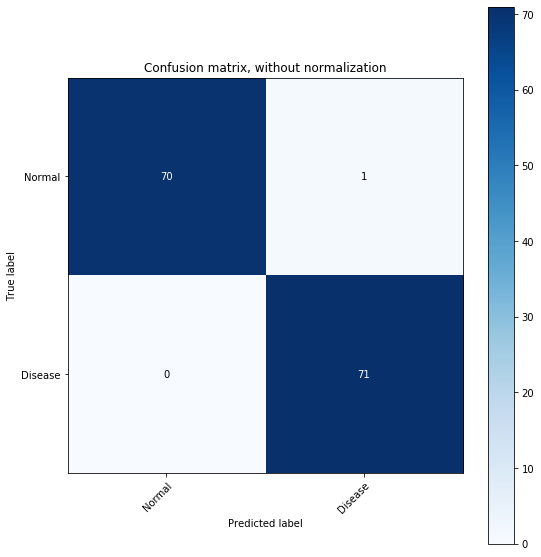

In [31]:
plot_confusion_matrix(y_train_sc.values[baseline_pipeline.testing_idxs], np.array(baseline_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

## Original architecture being fed (feature) reduced data

In [32]:
X_train_red = X_train_sc[feature_idxs]
print(X_train_red.shape)
X_train_red.head()

(142, 5)


,cp,chol,restecg,thalach,slope
214,0,249,0,144,1
208,2,188,1,139,1
193,0,282,0,142,1
224,0,239,1,126,1
169,0,203,0,155,0


In [33]:
X_valid_red = X_valid[feature_idxs]

# nn = build_dnn(num_features=X_train_red.shape[1])
# nn.summary()

In [34]:
nn = build_dnn(num_features=X_train_red.shape[1])
optimized_pipeline = ClusterPipeline(nn, [X_train_red, y_train_sc], [X_valid_red, y_valid], target_class=1)

optimized_pipeline.train_model(batch_size=10,epochs=10, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.707, Acc:0.8571
Prediction Accuracy
16/16 [==============================] - 0s 3ms/step
Scores on data set: loss=0.397 accuracy=1.0000
Fold Correct: 16
Running worker: 1
Fold: 1 -> Loss:0.719, Acc:0.8437
Prediction Accuracy
14/14 [==============================] - 0s 45us/step
Scores on data set: loss=0.383 accuracy=1.0000
Fold Correct: 14
Running worker: 2
Fold: 2 -> Loss:0.731, Acc:0.8125
Prediction Accuracy
14/14 [==============================] - 0s 32us/step
Scores on data set: loss=0.464 accuracy=0.9286
Fold Correct: 13
Running worker: 3
Fold: 3 -> Loss:0.747, Acc:0.8516
Prediction Accuracy
14/14 [==============================] - 0s 37us/step
Scores on data set: loss=0.883 accuracy=0.7857
Fold Correct: 11
Running worker: 4
Fold: 4 -> Loss:0.667, Acc:0.8984
Prediction Accuracy
14/14 [==============================] - 0s 28us/step
Scores on data set: loss=0.470 accuracy=1.0000
Fold Correct: 14
Running worker: 5
Fo

### Accuracy generally goes down
> **Culprit could be complicated architecture**

Confusion matrix, without normalization
[[0.91549296 0.08450704]
 [0.07042254 0.92957746]]


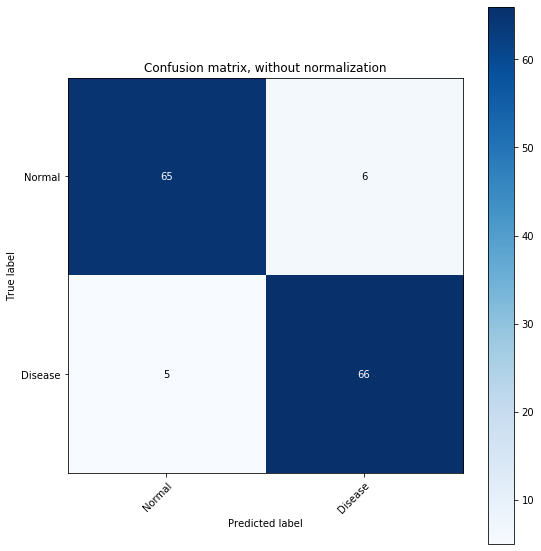

In [35]:
plot_confusion_matrix(y_train_sc.values[optimized_pipeline.testing_idxs], np.array(optimized_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

## Rebuilding a (simpler) DNN architecture

In [36]:
def build_shallow_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 15, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 10, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=5, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [37]:
nn = build_shallow_dnn(num_features=X_train_red.shape[1])

shallow_pipeline = ClusterPipeline(nn, [X_train_red, y_train_sc], [X_valid_red, y_valid], target_class=1)

shallow_pipeline.train_model(batch_size=10,epochs=20, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.277, Acc:0.9286
Prediction Accuracy
16/16 [==============================] - 0s 3ms/step
Scores on data set: loss=0.072 accuracy=1.0000
Fold Correct: 16
Running worker: 1
Fold: 1 -> Loss:0.287, Acc:0.9141
Prediction Accuracy
14/14 [==============================] - 0s 35us/step
Scores on data set: loss=0.072 accuracy=1.0000
Fold Correct: 14
Running worker: 2
Fold: 2 -> Loss:0.306, Acc:0.8828
Prediction Accuracy
14/14 [==============================] - 0s 38us/step
Scores on data set: loss=0.127 accuracy=1.0000
Fold Correct: 14
Running worker: 3
Fold: 3 -> Loss:0.297, Acc:0.9141
Prediction Accuracy
14/14 [==============================] - 0s 46us/step
Scores on data set: loss=0.463 accuracy=0.7143
Fold Correct: 10
Running worker: 4
Fold: 4 -> Loss:0.243, Acc:0.9297
Prediction Accuracy
14/14 [==============================] - 0s 54us/step
Scores on data set: loss=0.118 accuracy=1.0000
Fold Correct: 14
Running worker: 5
Fo

- ### Better accuracy than original architecure being fed reduced features
- ### Generally beats original non-subclustered analysis
- ### Not as good as orginal with subclustered data
    - **Thats expected however due to the implicit bias in the subclusters**


Confusion matrix, without normalization
[[0.91549296 0.08450704]
 [0.08450704 0.91549296]]


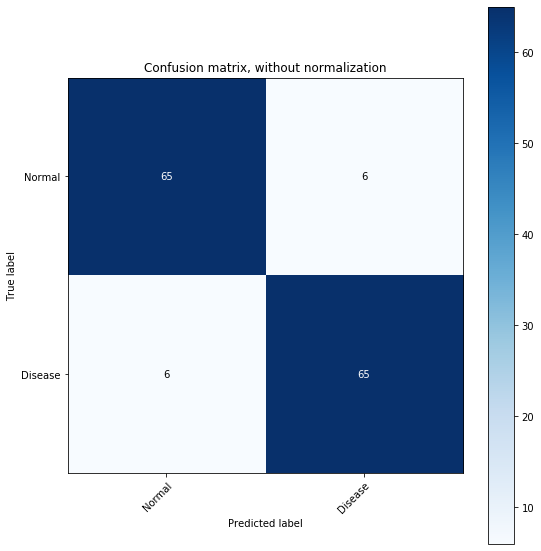

In [38]:
plot_confusion_matrix(y_train_sc.values[shallow_pipeline.testing_idxs], np.array(shallow_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

## NN w/ ALL features
- ### Performs just as well as original architecure with subcluster

In [43]:
nn = build_shallow_dnn(num_features=X_train_sc.shape[1])
shallow_pipeline = ClusterPipeline(nn, [X_train_sc, y_train_sc], [X_valid, y_valid], target_class=1)

shallow_pipeline.train_model(batch_size=10,epochs=20, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.250, Acc:0.9127
Prediction Accuracy
16/16 [==============================] - 0s 3ms/step
Scores on data set: loss=0.079 accuracy=1.0000
Fold Correct: 16
Running worker: 1
Fold: 1 -> Loss:0.137, Acc:0.9844
Prediction Accuracy
14/14 [==============================] - 0s 29us/step
Scores on data set: loss=0.077 accuracy=1.0000
Fold Correct: 14
Running worker: 2
Fold: 2 -> Loss:0.204, Acc:0.9687
Prediction Accuracy
14/14 [==============================] - 0s 37us/step
Scores on data set: loss=0.120 accuracy=1.0000
Fold Correct: 14
Running worker: 3
Fold: 3 -> Loss:0.150, Acc:0.9687
Prediction Accuracy
14/14 [==============================] - 0s 54us/step
Scores on data set: loss=0.315 accuracy=0.8571
Fold Correct: 12
Running worker: 4
Fold: 4 -> Loss:0.140, Acc:0.9609
Prediction Accuracy
14/14 [==============================] - 0s 58us/step
Scores on data set: loss=0.084 accuracy=1.0000
Fold Correct: 14
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.95774648 0.04225352]
 [0.         1.        ]]


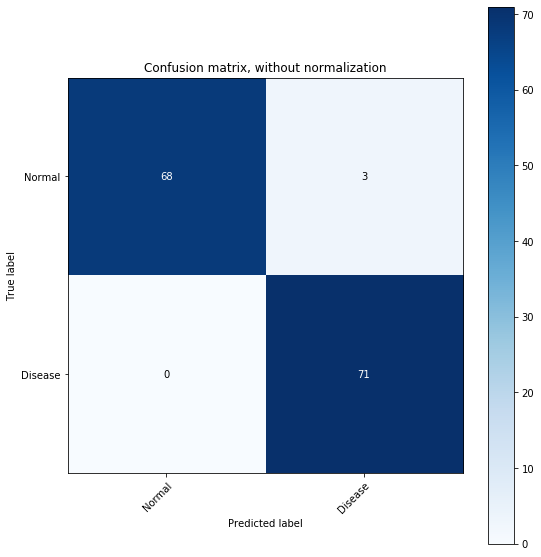

In [44]:
plot_confusion_matrix(y_train_sc.values[shallow_pipeline.testing_idxs], np.array(shallow_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

# SVM Analysis

In [51]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


param_grid = [
    {"dual":[False],"max_iter":[10000000], "penalty":["l1","l2"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["squared_hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]}
]

lsvc = LinearSVC()


clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM",LinearSVC())
])

def runSVM(X,y, X_valid,y_valid):
    
    clf_grid = Pipeline([
        ("scaler", StandardScaler()),
        ("SVMGrid",GridSearchCV(lsvc, param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=4))
    ])
    
    clf_grid.fit(X, y)
    grid = clf_grid.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("SVM", LinearSVC(**grid.best_params_))
    ])
    
    svm_clf.fit(X, y)
    print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

    _score = cross_val_score(svm_clf, X=X, y=y, cv=10)
    print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
    return svm_clf

## SVM trained on original data

In [52]:
original_svm = runSVM(X_train, y_train, X_valid, y_valid)

{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 0.742
SVM CV Accuracy: 0.861(+/- 0.105)


## Trained on subcluster vs control only

In [53]:
%time cluster_svm = runSVM(X_train_sc, y_train_sc, X_valid, y_valid)

{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l2', 'tol': 0.0001}
SVM Test Accuracy: 0.677
SVM CV Accuracy: 0.986(+/- 0.057)
CPU times: user 205 ms, sys: 6.18 ms, total: 211 ms
Wall time: 355 ms


## Trained on feature reduced subcluster
> ### Despite losing almost half the features, we still retain a high accuracy
> ### This may be an indication that the subclustering was infact a valid one

In [54]:
%time cluster_svm = runSVM(X_train_red, y_train_sc, X_valid_red, y_valid)

{'C': 10, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 0.645
SVM CV Accuracy: 0.930(+/- 0.106)
CPU times: user 218 ms, sys: 5.09 ms, total: 224 ms
Wall time: 1 s
